In [1]:
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
from scipy.signal.windows import tukey
from matplotlib.gridspec import GridSpec
import pywt

### Define some functions

In [2]:
def load_waveform(index_database, index_comp):

    # open data
    with xr.open_dataset('../data/modified_dataset.nc') as dset:
        chunks = dset['chunk']
        times = chunks.time

    # process the waveform
    waveform = chunks[index_database][index_comp].values
    taper = tukey(len(waveform), alpha=0.1)
    waveform = waveform * taper

    return times, waveform

def return_scalogram(waveform, dt, scales, mother_wavelet):

    # continuous wavelet transform
    coefs, freq = pywt.cwt(waveform, scales, mother_wavelet, dt)

    return np.abs(coefs), freq

def return_scale(frequency, freqs, scalogram):

    # find the index of the frequency
    index = np.argmin(np.abs(freqs - frequency))

    return scalogram[index]

### Select the exmaple, load the waveform data and define parameters

In [3]:
index_comp = 0 # index of the component
index_database = 38844 # index of the database
fs = 200 # sampling frequency in Hz
bins_0, bins_1 = 32, 32 # number of scale bins for the first and second wavelet transform

# load the waveform
times, waveform = load_waveform(index_database, index_comp)
times = times / fs # time in seconds

### Perform the first-order CWT

In [4]:
mother_wavelet_0 = 'cmor1-1' # mother wavelet for the first wavelet transform
freqmin_0, freqmax_0 = 5, (fs // 2) - 10 # frequency range for the first wavelet transform

frequencies_0 = np.geomspace(freqmin_0, freqmax_0, bins_0) 
scales_0 = pywt.frequency2scale(mother_wavelet_0, frequencies_0/ fs)
scalogram_0, _ = return_scalogram(waveform, 1/fs, scales_0, mother_wavelet_0)

### Retrieve the scale at a certain frequency bin

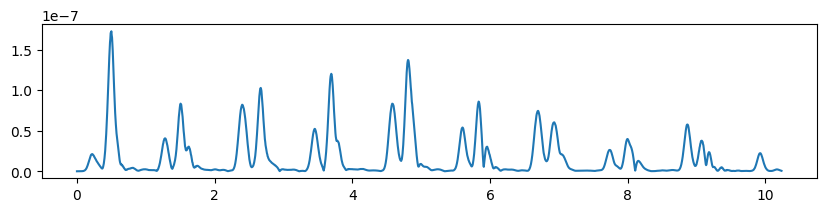

In [5]:
frequency = 20 # frequency in Hz
scale = return_scale(frequency, frequencies_0, scalogram_0)
plt.figure(figsize=(10, 2))
plt.plot(times, scale)

### Perfrom second-order CWT

In [6]:
mother_wavelet_1 = 'cmor2-1' # mother wavelet for the second wavelet transform
freqmin_1, freqmax_1 = 0.5, (fs // 2) - 20 # frequency range for the second wavelet transform

frequencies_1 = np.geomspace(freqmin_1, freqmax_1, bins_1)
scales_1 = pywt.frequency2scale(mother_wavelet_1, frequencies_1 / fs)
scalogram_1, _ = return_scalogram(scale, 1/fs, scales_1, mother_wavelet_1)

### Show the figure of the paper

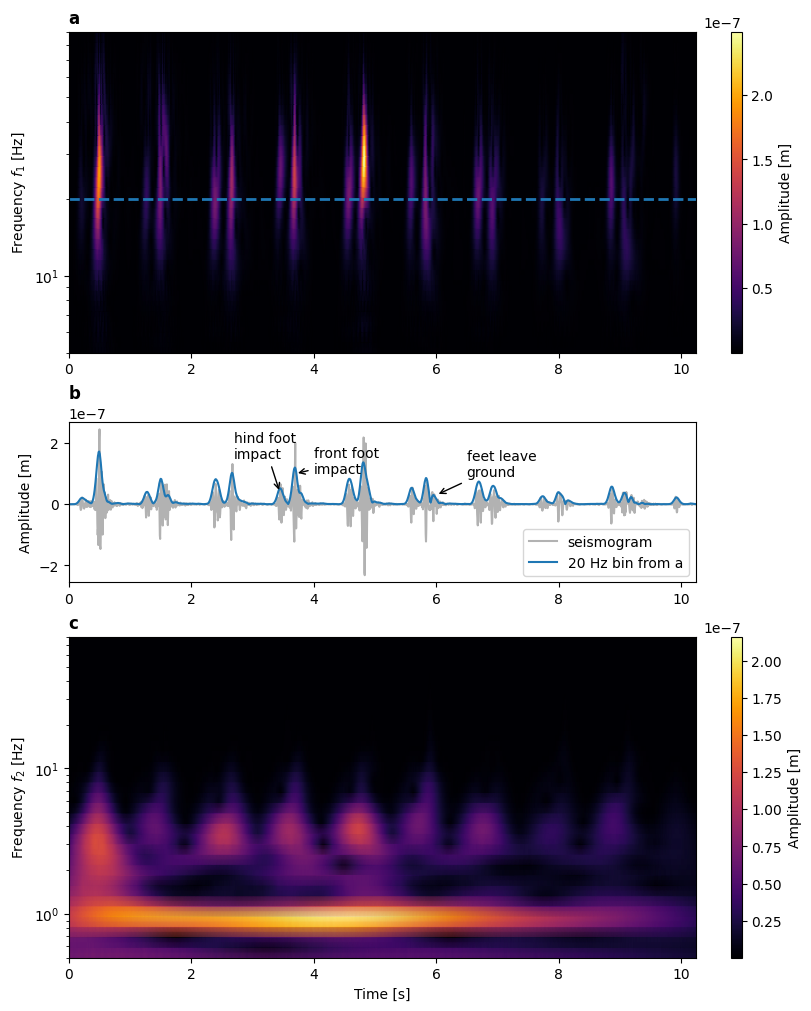

In [7]:
# Create figure and GridSpec
fig = plt.figure(figsize=(8, 10), constrained_layout=True)
gs = GridSpec(5, 2, width_ratios=[60, 1], figure=fig)

# Create subplots
ax1 = fig.add_subplot(gs[0:2, 0])
ax2 = fig.add_subplot(gs[2, 0], sharex=ax1)
ax3 = fig.add_subplot(gs[3:, 0], sharex=ax1)

# Set titles
ax1.set_title('a', loc='left', fontweight='bold')
#ax1.set_title('scalogram of the seismogram')
ax2.set_title('b', loc='left', fontweight='bold')
#ax2.set_title('%s Hz bin of the scalogram' % frequency)
ax3.set_title('c', loc='left', fontweight='bold')
#ax3.set_title('scalogram of the %s Hz bin' % frequency)

# Plot data
ax1.plot(times, waveform, 'k')
ax1.set_ylabel('Amplitude [m]')

img1 = ax1.pcolormesh(times, frequencies_0, scalogram_0, shading='gouraud', cmap='inferno')
ax1.axhline(frequency, color='C0', linestyle='--', linewidth=2)
ax1.set_ylim(np.min(frequencies_0), np.max(frequencies_0))
ax1.set_yscale('log')
ax1.set_ylabel('Frequency $f_1$ [Hz]')

# Add colorbar
cbar_ax1 = fig.add_subplot(gs[:2, 1])
fig.colorbar(img1, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('Amplitude [m]')

ax2.plot(times, waveform, 'k', alpha=0.3, label='seismogram')
ax2.plot(times, scale, label='20 Hz bin from a', color='C0')
ax2.annotate('front foot\nimpact', xy=(3.7, 10**-7), xytext=(4, 10**-7), arrowprops=dict(arrowstyle='->'))
ax2.annotate('hind foot\nimpact', xy=(3.45, 0.38*10**-7), xytext=(2.7, 1.5*10**-7), arrowprops=dict(arrowstyle='->'))
ax2.annotate('feet leave\nground', xy=(6, 0.3*10**-7), xytext=(6.5, 0.9*10**-7), arrowprops=dict(arrowstyle='->'))
ax2.set_ylabel('Amplitude [m]')
ax2.legend()


img2 = ax3.pcolormesh(times, frequencies_1, scalogram_1, shading='gouraud', cmap='inferno')
ax3.set_ylim(np.min(frequencies_1), np.max(frequencies_1))
ax3.set_yscale('log')
ax3.set_ylabel('Frequency $f_2$ [Hz]')
ax3.set_xlabel('Time [s]')

# Add colorbar
cbar_ax2 = fig.add_subplot(gs[3:, 1])
fig.colorbar(img2, cax=cbar_ax2, orientation='vertical')
cbar_ax2.set_ylabel('Amplitude [m]')

plt.show()

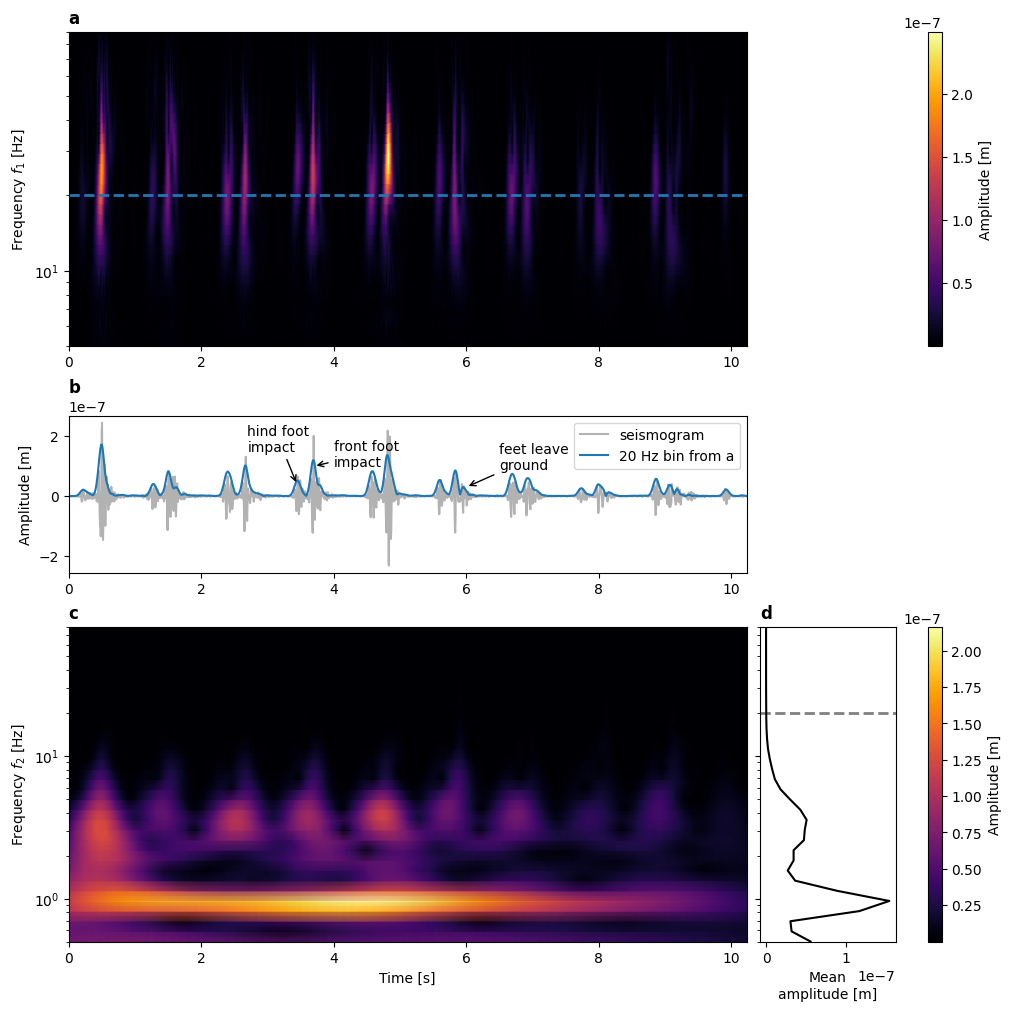

In [8]:
# Create figure and GridSpec
fig = plt.figure(figsize=(10, 10), constrained_layout=True)
gs = GridSpec(5, 3, width_ratios=[50, 10, 1], figure=fig)

# Create subplots
ax1 = fig.add_subplot(gs[0:2, 0])
ax2 = fig.add_subplot(gs[2, 0], sharex=ax1)
ax3 = fig.add_subplot(gs[3:, 0], sharex=ax1)

# Set titles
ax1.set_title('a', loc='left', fontweight='bold')
#ax1.set_title('scalogram of the seismogram')
ax2.set_title('b', loc='left', fontweight='bold')
#ax2.set_title('%s Hz bin of the scalogram' % frequency)
ax3.set_title('c', loc='left', fontweight='bold')
#ax3.set_title('scalogram of the %s Hz bin' % frequency)

# Plot data
ax1.plot(times, waveform, 'k')
ax1.set_ylabel('Amplitude [m]')

img1 = ax1.pcolormesh(times, frequencies_0, scalogram_0, shading='gouraud', cmap='inferno')
ax1.axhline(frequency, color='C0', linestyle='--', linewidth=2)
ax1.set_ylim(np.min(frequencies_0), np.max(frequencies_0))
ax1.set_yscale('log')
ax1.set_ylabel('Frequency $f_1$ [Hz]')

# Add colorbar
cbar_ax1 = fig.add_subplot(gs[:2, 2])
fig.colorbar(img1, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('Amplitude [m]')

ax2.plot(times, waveform, 'k', alpha=0.3, label='seismogram')
ax2.plot(times, scale, label='20 Hz bin from a', color='C0')
ax2.annotate('front foot\nimpact', xy=(3.7, 10**-7), xytext=(4, 10**-7), arrowprops=dict(arrowstyle='->'))
ax2.annotate('hind foot\nimpact', xy=(3.45, 0.38*10**-7), xytext=(2.7, 1.5*10**-7), arrowprops=dict(arrowstyle='->'))
ax2.annotate('feet leave\nground', xy=(6, 0.3*10**-7), xytext=(6.5, 0.9*10**-7), arrowprops=dict(arrowstyle='->'))
ax2.set_ylabel('Amplitude [m]')
ax2.legend()


img2 = ax3.pcolormesh(times, frequencies_1, scalogram_1, shading='gouraud', cmap='inferno')
ax3.set_ylim(np.min(frequencies_1), np.max(frequencies_1))
ax3.set_yscale('log')
ax3.set_ylabel('Frequency $f_2$ [Hz]')
ax3.set_xlabel('Time [s]')

# Add colorbar
cbar_ax2 = fig.add_subplot(gs[3:, 2])
fig.colorbar(img2, cax=cbar_ax2, orientation='vertical')
cbar_ax2.set_ylabel('Amplitude [m]')

ax4 = fig.add_subplot(gs[3:, 1])
ax4.set_title('d', loc='left', fontweight='bold')
ax4.axhline(frequency, color='grey', linestyle='--', linewidth=2)
ax4.plot(np.mean(scalogram_1, axis=1), frequencies_1, 'k')
ax4.set_xlabel('Mean\namplitude [m]')
ylim = ax3.get_ylim()
ax4.set_ylim(ylim)
ax4.set_yscale('log')
#ax4.set_xscale('log')
ax4.set_yticklabels([])
#ax4.text(1*10**-7, frequency+10, '$f_2 > f_1$', color='grey', va='center', ha='right')

plt.show()